# User Guide 4: Multiple Dimensions
## Introduction

Previously, we have only looked at simulating 1D Langevin problems. This is because they are both easier to understand and to compute. Beyond 1D, we must start considering arbitary end surfaces, some variables having no diffusion, correlation between noise terms etc! All these possibilities are hard to contain in a single general code. Also means we cannot use float values anymore and instead must use some form of "list" or similar object, adding additional complexity.

Therefore, we will only be considering a simple test case here. This will then be optimized by making more of our Python code into Cython. The idea is these tools and techniques presented should allow you to optimize PyFPT to run most efficiently for your own needs.

The multi-dimensional case is for more advanced users, and you will be expected to define a lot of the problem yourself. From now on, I'll expect you to have read (or at least skimmed) [Mazonka *et al* 1998](https://arxiv.org/abs/nucl-th/9809075) and [Jackson *et al* 2022](https://arxiv.org/abs/2206.11234). So go and read them now if you have not already!

## Multi-Field Radially Symmetric Inflation
A basic test case is to consider multi-field radially symmetric inflation See [Assadullahi *et al* 2016](https://arxiv.org/abs/1604.04502). This is similair to the previous case of quadratic inflation considered bt for multiple fields. The potential has the form
$$
V = \frac{m^2 r^2}{2} \, ,
$$
where
$$
r^2 = \sum_{i=1}^n \phi_i^2 \, ,
$$
and $\phi_i$ is the $i$th field and there are $n$ of them. Each field follows it's own slow-roll Langevin equation (a subscript is used to denote a derivative)
$$
\frac{{\rm d} \phi_i}{{\rm d} N} = -\frac{V_{\phi_i}}{3H^2}+\frac{H}{2\pi}\hat{\xi}
$$
where
$$
H^2 = \frac{V(\phi)}{3M_{\rm pl}} \, ,
$$
and $\hat{\xi}$ is a unitless noise. The hat denotes it's unitless. As the potential depends solely on $r$, using [Itô's lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma), one can write a Langevin equation
$$
\frac{{\rm d} r}{{\rm d} N} = -\frac{V_{r}}{3H^2}+\frac{H^2}{8\pi^2 r}(n-1)+\frac{H}{2\pi}\hat{\xi}
$$
for $r$ which describes full evoluation of the FPT problem if the end surace is at $r_{\rm end}$.


So we can simulate the evolution of each field seperately and use a custom end surface which is radially symmetric. Then we can check our results using the Langevin equation for $r$, given in the ``fpt.analytics`` module.

## Reformulating the Problem
### Theory
As the multi-dimensional FPT problem can be very complex, PyFPT cannot just accept the drift, diffusion, and a single end value as before. Instead, the user will have to define the Euler-Maruyama step and the importance sampling step themselves. The general Euler-Maruyama step with importance sampling is given by
$$
\Delta \mathbf{x} = [\mathbf{D}(\mathbf{x}, t)+\mathbf{B}(\mathbf{x}, t)]\Delta t + \mathbf{\xi} \sqrt{\Delta t} \, ,
$$
where $\mathbf{x}$ is the stochastic varaible vector, $\mathbf{D}$ is the drift vector, $\mathbf{B}$ is the general bias vector and $\mathbf{\xi}$ is the diffusion noise matrix. It is not unitless as it does not have a hat as above. Boldface is used to indicate vectors and matrices. The noise matrix is defined by
$$
\langle \xi_i(t) \xi_j (t') \rangle = S_{ij} \delta (t-t') \, ,
$$
where $S_{ij}$ is the amplitude of the correlation between $\xi_i$ and $\xi_j$. In the 1D case, this would correspond to the square of the diffusion term. The off-diagonal terms give the correlation between variables. 

Importance sampling, which is given by thw eight of the path $w$, is tracked with the varible $A$, where
$$
w = e^A \, .
$$
It has an initial value of 0 and is updated as the simulation progresses using
$$
\Delta A = \bigg[\frac{\mathbf{\xi} \sqrt{\Delta t}}{2} + \mathbf{B}(\mathbf{x}, t) \Delta t \bigg]^T \cdot\mathbf{S}^{-1}(\mathbf{x}, t) \cdot \mathbf{B}(\mathbf{x}, t) \, .
$$

### Implementation
The above equations are implemented into the code as a single function, the ``update`` function (see the docs), which updates $\mathbf{x}$ term by term, i.e. updates each element of $\mathbf{x}$, and returns $\Delta A$. We can update $\mathbf{x}$ without returning it, as being a memoryview object it is mutable. NumPy should be avoided as much as possible, as this can slow down the code by factor of up to 1000. Instead, packages such as ``mpmath`` should be used.

You can plug in the equations you wish to simulate into the above and simplify them as much as possible to improve the efficiency. 

**It is up to you how efficient, or inefficient, PYFPT is in the multi-dimensional case!**

### Example Implementation
Let's simulate this multi-field case for two fields in diffusion domination as a simple test case. Here, the change in the importance sampling varaible $\Delta A$ can be simplified to 
$$
 \Delta A = \sum_i \frac{\mathcal{A}_{i}}{2}(2\Delta W_i + \mathcal{A}_{i} \Delta t) \, ,
$$
where $\mathcal{A}$ is the bias amplitude for each field propagated and $\Delta W_i = \hat{\xi}_i \sqrt{\Delta t}$ is the Weiner step. 

In [1]:
r_in = 42**0.5  # From N=0.25*(phi_in**2-phi_end**2) = 10
r_end = 2**0.5  # Where slow-roll violation occurs
r_end_squared = r_end**2
pi = 3.141592653589793
sqirt_6 = 6**0.5

# Using a large mass so diffusion domination occurs.
m = 1.
diffuse_const = m/(2*pi*sqirt_6)

# Now let's define functions which update the provided variable.
# The bias definition needs to be consistent between the two
def update(vec, N, dN, dW):
    r = (vec[0]**2+vec[1]**2)**0.5
    vec[0] += (-2*vec[0]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[0]
    vec[1] += (-2*vec[1]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[1]
    
    return bias*(0.5*bias*dN + dW[0]) + bias*(0.5*bias*dN + dW[1])


def end_cond(vec, N):
    r_squared = vec[0]**2+vec[1]**2
    if r_squared <= r_end_squared :
        return 1
    else:
        return 0

Let's also define the parameters needed for the simulation

In [2]:
import pyfpt as fpt
import numpy as np
import matplotlib.pyplot as plt

import mpl_style
plt.style.use(mpl_style.paper_style)

dN = 0.02
bias = 0.2
# Start at equal values for the two fields
vec_in = np.array([4, (r_in**2-4**2)**0.5])

num_runs = 2*10**5

In [3]:
bin_centres, heights, errors =\
    fpt.numerics.is_simulation_ndim(update, vec_in, dN, num_runs, end_cond,
                                    estimator='naive')

The simulations took: 524.0139720660009 seconds


As before, we can check our numerical results against an analytical prediction. 

As this requires a numerical integration, it could take awhile.

In [4]:
# Using the definition of the reduced potential, see https://arxiv.org/abs/1707.00537
v0 = (m**2)/(48*(np.pi**2))
# There are two fields
n = 2

analytical_bin_centres = np.linspace(5, 50)
analytic_pdf_values =\
    fpt.analytics.quadratic_inflation_multi_field_pdf(analytical_bin_centres, v0, n, r_in)

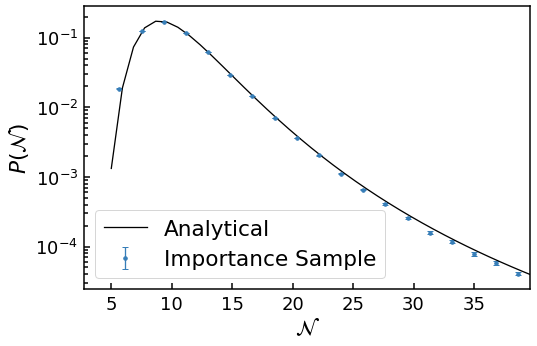

<Figure size 576x374.4 with 0 Axes>

In [5]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
             label='{0}'.format(r'Importance Sample'))
plt.plot(analytical_bin_centres, analytic_pdf_values,
         label='{0}'.format('Analytical'), color='k')
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.ylim(bottom = 0.6*np.min(heights))
plt.xlim(right = bin_centres[np.argmin(heights)]+1)
plt.legend()
plt.show()
plt.clf()

Which agrees with the analytical predictions within the estimated errors.

## An Aside - Approaching the End Surface
For diffusion domination, as is the case considered here, no matter how small the step a small error will always be produced when the run finishes as it will "over step" the end surface. For large step sizes, this can cause a large systematic error. The 1D code handles this automatically by reducing the time step when the propagated variable is 4 standard deviations away from the end surface. This approach is always valid in the 1D problem

However, a universal definition for "near the end surface" cannot be defined for an arbitary number of dimensions considered here. Therefore none is done automatically. Instead, the user can define their own by having the ``end_condition`` function above return -1 while the propagated variable is close to the end surface. Unfortunatly, this can slow down the code considerably if implemented. 

This issue is not a major problem here, but it worth being aware of and to look out for it if it occurs in your simulation.

Where the tail now also agrees with the analytical prediction! So we'll use this approaching end surface method throughout the rest of this notebook.

In the simpler 1D case, the code already did this automatically!

## Improving the Efficiency
We can improve the efficiency by making using Cython more. First, we can simply compile the required function into a Cython function. We need to write a function which updates each element of the provided vector, returns the change in $A$, as well as applying anything else such as a reflective boundary.

In [6]:
# Remember to load Cython
%load_ext cython

Remember, Cython needs all of the constants defined within the complied cell.

In [7]:
%%cython -a
r_in = 42**0.5  # From N=0.25*(phi_in**2-phi_end**2) = 10
r_end = 2**0.5  # Where slow-roll violation occurs
r_end_squared = r_end**2
pi = 3.141592653589793
sqirt_6 = 6**0.5

# Using a large mass so diffusion domination occurs.
m = 1.
diffuse_const = m/(2*pi*sqirt_6)
bias = 0.2

# Now let's define functions which update the provided variable.
# The bias definition needs to be consistent between the two
def update_cython(vec, N, dN, dW):
    r = (vec[0]**2+vec[1]**2)**0.5
    vec[0] += (-2*vec[0]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[0]
    vec[1] += (-2*vec[1]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[1]
    
    return bias*(0.5*bias*dN + dW[0]) + bias*(0.5*bias*dN + dW[1])


def end_cond_cython(vec, N):
    r_squared = vec[0]**2+vec[1]**2
    if r_squared <= r_end_squared :
        return 1
    else:
        return 0

and then run it again

In [8]:
bin_centres, heights, errors =\
    fpt.numerics.is_simulation_ndim(update_cython, vec_in, dN, num_runs, end_cond_cython,
                                    estimator='naive')

The simulations took: 456.7390512339989 seconds


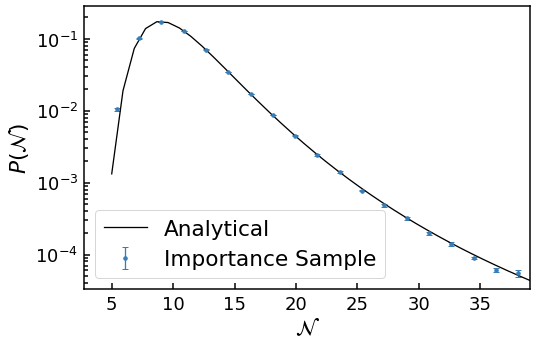

<Figure size 576x374.4 with 0 Axes>

In [9]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
             label='{0}'.format(r'Importance Sample'))
plt.plot(analytical_bin_centres, analytic_pdf_values,
         label='{0}'.format('Analytical'), color='k')
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.ylim(bottom = 0.6*np.min(heights))
plt.xlim(right = bin_centres[np.argmin(heights)]+1)
plt.legend()
plt.show()
plt.clf()

So we only gained an efficiency saving of ~30%. A good start but we can improve the efficiency even further using Cython notation.

In [10]:
%%cython -a
cdef double pi = 3.141592653589793
cdef double sqirt_6 = 6**0.5
cdef double r_end_squared = 2  # Where slow-roll violation occurs
cdef double r
cdef double r_squared

# Using a large mass so diffusion domination occurs.
cdef double m = 1.
cdef double diffuse_const = m/(2*pi*sqirt_6)
cdef double bias = 0.2


cpdef double update_cython2(double [:] vec, double N, double dN,
                           double [:] dW):
    r = (vec[0]**2+vec[1]**2)**0.5
    vec[0] += (-2*vec[0]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[0]
    vec[1] += (-2*vec[1]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[1]
    
    return bias*(0.5*bias*dN + dW[0]) + bias*(0.5*bias*dN + dW[1])

cpdef int end_cond_cython2(double [:] vec, double N):
    r_squared = vec[0]**2+vec[1]**2
    if r_squared <= r_end_squared:
        return 1
    else:
        return 0

In [11]:
bin_centres, heights, errors =\
    fpt.numerics.is_simulation_ndim(update_cython2, vec_in, dN, num_runs, end_cond_cython2,
                                    estimator='naive')

The simulations took: 211.38033416599865 seconds


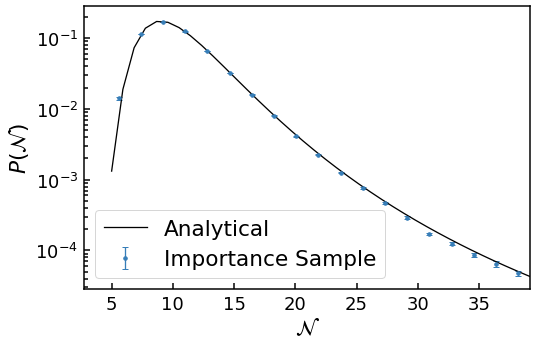

<Figure size 576x374.4 with 0 Axes>

In [12]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
             label='{0}'.format(r'Importance Sample'))
plt.plot(analytical_bin_centres, analytic_pdf_values,
         label='{0}'.format('Analytical'), color='k')
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.ylim(bottom = 0.6*np.min(heights))
plt.xlim(right = bin_centres[np.argmin(heights)]+1)
plt.legend()
plt.show()
plt.clf()

This is better, as it's now ~3.5 times faster than using a Python function!

Note how we've now defined a fully Cython function, which we are passing through a Python interface, to then use in an another Cython function? And this is happening at each step in $\Delta N$? What if we could just do this in one Cython Code?

Thankfully, this is can be done by relatively simply by editing and then locally compiling the Cython code of PyFPT and using ``fpt.numerics.re_processing``, as we've already defined a Cython way the function to be propagated.

### Fully Cython Simulation
To make the simulation fully Cython, let's copy the multi-dimensional code from the .pyx file of PyFPT and simply edit it to include our function.

The **original** code is

In [13]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [14]:
%%cython -a
import numpy as np

cdef double e = 2.718281828459045



cdef int end_condition(double x, double t, double x_end, double direction):
    # May seem strange, but this logic means you have x_in either side of x_end
    if direction*x <= direction*x_end:
        return 1
    else:
        return 0


cdef list simulation_diff_nD(double [:] x_in, double x_end, double t_i, double t_f,
                                        double dt, update, rng):
    cdef double t, sqrt_dt, A
    cdef int i = 0
    cdef int len_rand_nums = 1000
    cdef int num_dims = len(x_in)

    cdef double direction = x_in[0]-x_end

    cdef double [:] x = np.copy(x_in)
    cdef double [:, :] rand_nums = rng.normal(0, 1, size=(num_dims, len_rand_nums))
    
    cdef double [:] dW = rand_nums[:, 0]

    sqrt_dt = dt**0.5
    t = t_i
    A = 0.0

    while t<t_f:
        # Define the Wiener step, using the pre-drawn random numbers.
        for j in range(num_dims):
            dW[j] = rand_nums[j, i]*sqrt_dt
        # Step in x and A simultanioues
        A += update(x, t, dt, dW)
        t += dt
        i += 1
        # Using 1/0 for True/False
        if end_condition(x[0], t, x_end, direction) == 1:
            break
        # If all of the random numbers have been used up, need to update them.
        # This should still be more efficient than drawing a new random number
        # each time.
        if i == len_rand_nums:
            rand_nums = rng.normal(0, 1, size=(num_dims, len_rand_nums))
            i = 0
    return [t, e**(-A)]


#A let's us calculate the bias w=e^-A is the bias, which propagated along with 
#the importance sample path.
#See Eq. (33) of arXiv:nucl-th/9809075v1 for more info
cdef list simulation_diff_nD_custom_end(double [:] x_in, double t_i, double t_f,
                                        double dt, end_cond, update, rng):
    cdef double t, sqrt_dt, A
    cdef int i = 0
    cdef int len_rand_nums = 1000
    cdef int reduced_step = 0
    cdef int num_dims = len(x_in)
    cdef int end_cond_value

    cdef double [:] x = np.copy(x_in)
    cdef double [:, :] rand_nums = rng.normal(0, 1, size=(num_dims, len_rand_nums))
    
    cdef double [:] dW = rand_nums[:, 0]

    sqrt_dt = dt**0.5
    t = t_i
    A = 0.0

    while t<t_f:
        # Define the Wiener step, using the pre-drawn random numbers.
        for j in range(num_dims):
            dW[j] = rand_nums[j, i]*sqrt_dt
        # Step in x and A simultanioues
        A += update(x, t, dt, dW)
        t += dt
        i += 1
        # Using 1/0 for True/False
        end_cond_value = end_cond(x, t)
        if end_cond_value == 1:
            break
        elif end_cond_value == -1 and reduced_step == 0:
            dt = dt/1000
            sqrt_dt = dt**0.5
            reduced_step = 1
        elif end_cond_value == 0 and reduced_step == 1:
            dt = 1000*dt
            sqrt_dt = dt**0.5
            reduced_step = 0
            
        # If all of the random numbers have been used up, need to update them.
        # This should still be more efficient than drawing a new random number
        # each time.
        if i == len_rand_nums:
            rand_nums = rng.normal(0, 1, size=(num_dims, len_rand_nums))
            i = 0
    return [t, e**(-A)]


cpdef importance_sampling_simulations_ndim(double [:] x_in, double t_i, double t_f, double dt,
                                           int num_runs, end_cond, update):
    rng = np.random.default_rng()
    if isinstance(end_cond, float) is True\
        or isinstance(end_cond, int) is True:
        results =\
            [simulation_diff_nD(x_in, end_cond, t_i, t_f, dt, update, rng)
             for i in range(num_runs)]
    elif callable(end_cond):
        results =\
            [simulation_diff_nD_custom_end(x_in, t_i, t_f, dt, end_cond, update, rng)
             for i in range(num_runs)]
    else:
        raise ValueError('end_cond must be number or function.')
    
    ts, ws = [[results[i][j] for i in range(num_runs)] for j in range(2)]
    return ts, ws

There is alot of functionality we don't need here, such as the code for a 1D end surface, so let's remove it.

We also don't have to provide the ``update`` and ``end_cond`` functions as arguments, as they are already in the code. So we can just change their labels to match what is already there.


The both simplified and updated to our needs code is below.

In [15]:
%%cython -a
import numpy as np
cdef double e = 2.718281828459045

cdef double pi = 3.141592653589793
cdef double sqirt_6 = 6**0.5
cdef double r_end_squared = 2  # Where slow-roll violation occurs
cdef double r  # Already assign memeory for r
cdef double r_squared

# Using a large mass so diffusion domination occurs.
cdef double m = 1.
cdef double diffuse_const = m/(2*pi*sqirt_6)
cdef double bias = 0.2


cdef double update(double [:] vec, double N, double dN,
                   double [:] dW):
    r = (vec[0]**2+vec[1]**2)**0.5
    vec[0] += (-2*vec[0]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[0]
    vec[1] += (-2*vec[1]/(r**2) + bias * diffuse_const * r) * dN\
        + diffuse_const * r * dW[1]
    
    return bias*(0.5*bias*dN + dW[0]) + bias*(0.5*bias*dN + dW[1])

cdef int end_cond(double [:] vec, double N):
    r_squared = vec[0]**2+vec[1]**2
    if r_squared <= r_end_squared:
        return 1
    else:
        return 0


#A let's us calculate the bias w=e^-A is the bias, which propagated along with 
#the importance sample path.
#See Eq. (33) of arXiv:nucl-th/9809075v1 for more info
cdef list simulation_diff_nD_custom_end(double [:] x_in, double t_i, double t_f,
                                        double dt, rng):
    cdef double t, sqrt_dt, A
    cdef int i = 0
    cdef int len_rand_nums = 1000
    cdef int reduced_step = 0
    cdef int num_dims = len(x_in)
    cdef int end_cond_value

    cdef double [:] x = np.copy(x_in)
    cdef double [:, :] rand_nums = rng.normal(0, 1, size=(num_dims, len_rand_nums))
    
    cdef double [:] dW = rand_nums[:, 0]

    sqrt_dt = dt**0.5
    t = t_i
    A = 0.0

    while t<t_f:
        # Define the Wiener step, using the pre-drawn random numbers.
        for j in range(num_dims):
            dW[j] = rand_nums[j, i]*sqrt_dt
        # Step in x and A simultanioues
        A += update(x, t, dt, dW)
        t += dt
        i += 1
        # Using 1/0 for True/False
        end_cond_value = end_cond(x, t)
        if end_cond_value == 1:
            break
        elif end_cond_value == -1 and reduced_step == 0:
            dt = dt/1000
            sqrt_dt = dt**0.5
            reduced_step = 1
        elif end_cond_value == 0 and reduced_step == 1:
            dt = 1000*dt
            sqrt_dt = dt**0.5
            reduced_step = 0
            
        # If all of the random numbers have been used up, need to update them.
        # This should still be more efficient than drawing a new random number
        # each time.
        if i == len_rand_nums:
            rand_nums = rng.normal(0, 1, size=(num_dims, len_rand_nums))
            i = 0
    return [t, e**(-A)]


cpdef importance_sampling_simulations_ndim(double [:] x_in, double t_i, double t_f, double dt,
                                           int num_runs):
    rng = np.random.default_rng()
    results =\
        [simulation_diff_nD_custom_end(x_in, t_i, t_f, dt, rng)
         for i in range(num_runs)]
    
    ts, ws = [[results[i][j] for i in range(num_runs)] for j in range(2)]
    return ts, ws

Now let's run this code, using the code in ``fpt.numerics.is_simulation_ndim`` as a guide for the multi-processing etc, which is like what we did before but are now directly running the simulation, so we will have to apply our own post-processing.

**Remember to remove the ``update`` argument, as this function is included in our Cython code already. Also, we need to relabel our variables to fit the general format of this code. See below**

In [16]:
from timeit import default_timer as timer

# Quick way to get general code to work for our chosen variables
t_in = 0
t_f = 1000
# Time how long the simulation runs take
start = timer()

fpt_values, w_values =\
    importance_sampling_simulations_ndim(vec_in, t_in, t_f, dN,
                                         num_runs)

end = timer()
print(f'The simulations took: {end - start} seconds')

# Convert to numpy arrays
fpt_values = np.array(fpt_values)
w_values = np.array(w_values)

The simulations took: 81.43082847199912 seconds


Now apply post-processing

In [17]:
bin_centres, heights, errors =\
    fpt.numerics.re_processing(fpt_values, weights=w_values,
                               estimator='naive')

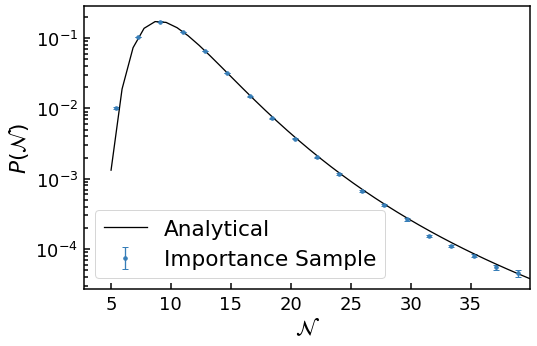

<Figure size 576x374.4 with 0 Axes>

In [18]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
             label='{0}'.format(r'Importance Sample'))
plt.plot(analytical_bin_centres, analytic_pdf_values,
         label='{0}'.format('Analytical'), color='k')
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.ylim(bottom = 0.6*np.min(heights))
plt.xlim(right = bin_centres[np.argmin(heights)]+1)
plt.legend()
plt.show()
plt.clf()

**Which is 50 times faster than our pure Python code!** As it took 10 seconds rather than ~500 seconds

Although this is done for a simple example, hopefully you can apply the logic and steps used to your own problem and gain additional efficiencies. The general rules for keeping your code efficient are

* Don't use NumPy in your ``update`` function.
* Update each element in your position vector individually.
* You can locally compile the ``update`` function into Cython.
* You can use Cython techniques to maximize the efficiency of this function.
* Finally, this function can be included in the PyFPT's Cython code directly

Hopefully you can follow these steps and used the worked example to further optimize your particular problem!

#### Even more efficiency

I have not even talked about how drawing the random numbers also can be optimized! 

I'm sure more experience Cython users have already spotted other inefficiencies as well! And if you did, feel free to let me know!

Multi-processing could also be done. Although I found it gave subtle but non-negligible error due to the memoryview objects and is not currently used. But you might be able to get it working. If you do, please do let me know how!

# The End

Well done! You got to the end!

I hope these guides have been helpful. Do let me know if there are any mistakes or if there are any improvements I could make.

Joe Jackson